# Create plots for Figure 17

In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy
from PDEsolvers import KS_Periodic

In [2]:
# User inputs
data_name = 'KS_Eqn_exp5'  # Prefix of data files
folder_name = 'KS_exp5h/'  # Folder to be created for saved output

In [3]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])


KS_exp5h/KS_Eqn_exp5_2019_10_18_07_18_03_991009_model.pkl
0.020176639780402184
0.01660362258553505


In [4]:
# Load data
data_test1 = np.load(('./data/%s_test1_x.npy' % data_name))
data_test2 = np.load(('./data/%s_test2_x.npy' % data_name))
data_test3 = np.load(('./data/%s_test3_x.npy' % data_name))
data_test4 = np.load(('./data/%s_test4_x.npy' % data_name))
data_test5 = np.load(('./data/%s_test5_x.npy' % data_name))
data_test_all = np.vstack([data_test1,data_test2,data_test3,data_test4,data_test5])

In [5]:
import helperfns

max_shifts_to_stack = helperfns.num_shifts_in_stack(params)
data_test_all_tensor = helperfns.stack_data(data_test_all, max_shifts_to_stack, params['val_len_time'])

In [6]:
# Network outputs

tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    # Prediction
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs:0"]
    for k in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(k)+"/outputs:0")
    test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
test_outputs = np.asarray(test_outputs)

INFO:tensorflow:Restoring parameters from ./KS_exp5h/KS_Eqn_exp5_2019_10_18_07_18_03_991009_model.ckpt


In [7]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            cmap = matplotlib.colors.ListedColormap(['red'])
            #ax.plot(X[j,:],Y[j,:],Z[j,:],'-r',linewidth=2,alpha=1,zorder=2)
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
            #ax.plot(X[j,:],Y[j,:],Z[j,:],'-b',linewidth=2,alpha=1,zorder=2)
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
        lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

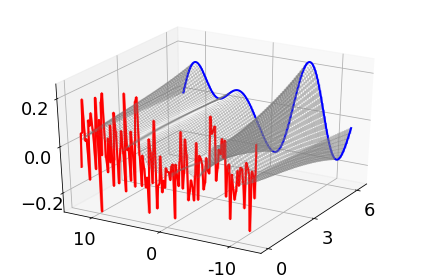

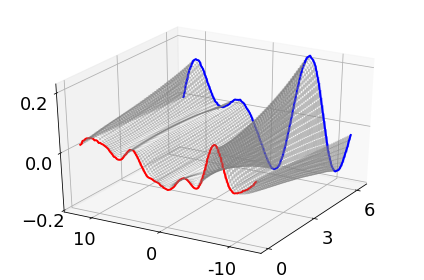

In [8]:
# Test data, IC = 1

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-0.2, 0, 0.2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-0.2, 0, 0.2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()

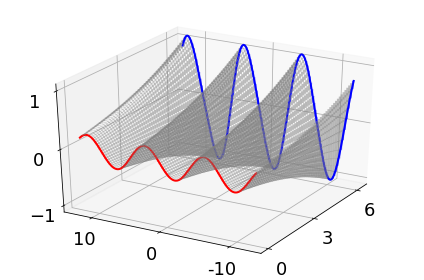

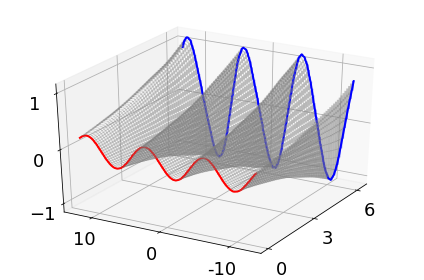

In [9]:
# Test data, IC = 1008

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1008

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()

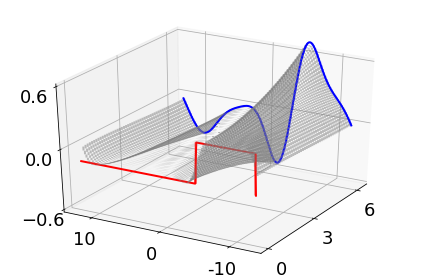

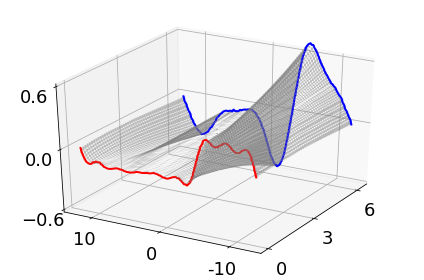

In [10]:
# Test data, IC = 2013

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 2013

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()

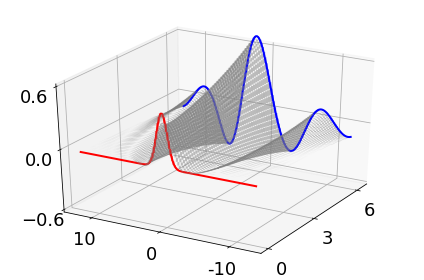

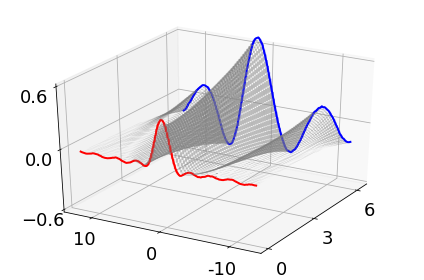

In [11]:
# Test data, IC = 3003

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 3003

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()

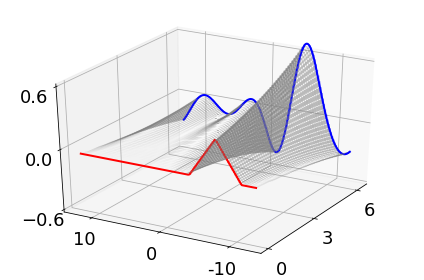

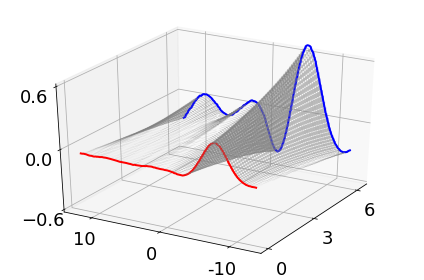

In [12]:
# Test data, IC = 4002

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 4002

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()
plt.show()